In [315]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

pd.options.display.max_columns = 120


In [316]:
def load_data(file_path):
    """Load data from a CSV file into a pandas DataFrame."""
    return pd.read_csv(file_path)

In [317]:
train_dir = Path("../datasets/NR_split_on_skiers/train_val") 
train_files = list(train_dir.glob("*.csv"))
print(f"Training files: {len(train_files)}")

test_dir = Path("../datasets/NR_split_on_skiers/test")
test_files = list(test_dir.glob("*.csv"))
print(f"Test files: {len(test_files)}")     

Training files: 10
Test files: 2


In [318]:
# Parameters regarding how far back in time to feed
history = 10
lag = 5
output_col = "Gear"

In [319]:
info_columns = ['tt_s', 'Lap', 'Gear', 'ns1:LatitudeDegrees', 'ns1:LongitudeDegrees', 'Sport'] 
feature_columns_pole_data = ['speed_kmph', 'power_w', 'frequency_ppm', 'thrust_left_ms', 'thrust_right_ms', 'impulse_left_ns', 'impulse_right_ns', 'force_meanl_n', 'force_meanr_n', 'f_tot_mean_n']
feature_columns_gnss = ['ns1:AltitudeMeters', 'ns2:Speed', 'ns2:RunCadence', 'ns2:Watts']

feature_columns = feature_columns_pole_data + feature_columns_gnss

In [320]:
dfs = [load_data(file) for file in train_files]
test_dfs = [load_data(file) for file in test_files]
  
def make_sure_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

dfs = [make_sure_numeric(df, feature_columns_gnss + feature_columns_pole_data) for df in dfs]
test_dfs = [make_sure_numeric(df, feature_columns_gnss + feature_columns_pole_data) for df in test_dfs]

In [321]:
# set gear 2.0V and 2.0H to 2
for df in dfs + test_dfs:
    df['Gear'] = df['Gear'].replace({'2.0V': '2', '2.0H': '2'})


In [322]:
def add_incline_from_altitude(df):
    df = df.sort_values(by='tt_s').reset_index(drop=True)
    df['incline'] = df['ns1:AltitudeMeters'].diff().fillna(0)
    return df

dfs = [add_incline_from_altitude(df) for df in dfs]
test_dfs = [add_incline_from_altitude(df) for df in test_dfs]

# normalize incline with mean and std from training data
all_incline = pd.concat([df['incline'] for df in dfs])
incline_mean = all_incline.mean()
incline_std = all_incline.std()

for df in dfs:
    df['incline'] = (df['incline'] - incline_mean) / incline_std

for df in test_dfs:
    df['incline'] = (df['incline'] - incline_mean) / incline_std
feature_columns.append('incline')
# remove alitude column
feature_columns.remove('ns1:AltitudeMeters')

In [323]:
def add_ratios(df):
    df = df.copy()
    df["force_ratio"] = df["force_meanl_n"]/(df["force_meanl_n"] + df["force_meanr_n"] + 1e-6)
    df["thrust_ratio"] = df["thrust_left_ms"]/(df["thrust_left_ms"] + df["thrust_right_ms"] + 1e-6)
    df["impulse_ratio"] = df["impulse_left_ns"]/(df["impulse_left_ns"] + df["impulse_right_ns"] + 1e-6)
    return df

dfs = [add_ratios(df) for df in dfs]
test_dfs = [add_ratios(df) for df in test_dfs]
feature_columns = feature_columns_pole_data + feature_columns_gnss + ["force_ratio", "thrust_ratio", "impulse_ratio"]

In [324]:
def create_lagged_features(df, feature_columns, history, lag):
    df = df.copy()
    for h in range(1, lag + 1):
        for col in feature_columns:
            df[f"{col}_lag{h}"] = df[col].shift(h)
    for h in range(history):
        for col in feature_columns:
            df[f"{col}_mean"] = df[col].shift(h).rolling(window=lag).mean()
            df[f"{col}_std"] = df[col].shift(h).rolling(window=lag).std()
    df = df.dropna().reset_index(drop=True)
    return df

dfs = [create_lagged_features(df, feature_columns, history, lag) for df in dfs]
test_dfs = [create_lagged_features(df, feature_columns, history, lag) for df in test_dfs]

feature_columns_lagged = []
for h in range(1, lag + 1):
    for col in feature_columns:
        feature_columns_lagged.append(f"{col}_lag{h}")
for col in feature_columns:
        feature_columns_lagged.append(f"{col}_mean")
        feature_columns_lagged.append(f"{col}_std")
feature_columns = feature_columns + feature_columns_lagged


/var/folders/js/3kl4pzld50qdxyxznqpfnbz00000gn/T/ipykernel_65749/133474891.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_mean"] = df[col].shift(h).rolling(window=lag).mean()
/var/folders/js/3kl4pzld50qdxyxznqpfnbz00000gn/T/ipykernel_65749/133474891.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_std"] = df[col].shift(h).rolling(window=lag).std()
/var/folders/js/3kl4pzld50qdxyxznqpfnbz00000gn/T/ipykernel_65749/133474891.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the 

In [325]:
def add_acceleration(df):
    df = df.copy()
    df['acceleration'] = df['ns2:Speed'].diff()
    df['acceleration'].fillna(0, inplace=True)
    return df
dfs = [add_acceleration(df) for df in dfs]
test_dfs = [add_acceleration(df) for df in test_dfs]
feature_columns.append('acceleration')

/var/folders/js/3kl4pzld50qdxyxznqpfnbz00000gn/T/ipykernel_65749/1663801313.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['acceleration'].fillna(0, inplace=True)
/var/folders/js/3kl4pzld50qdxyxznqpfnbz00000gn/T/ipykernel_65749/1663801313.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

In [326]:
def _stable_indices(y, n=2):
    """Return positional indices where the label has been stable for n before and n after."""
    y = y.reset_index(drop=True)
    idx = []
    for i in range(n, len(y) - n):
        c = y.iloc[i]
        # use iloc for positional comparisons
        if all(y.iloc[i - j] == c and y.iloc[i + j] == c for j in range(1, n + 1)):
            idx.append(i)
    return idx

def accuracy_when_stable_gear(y, pred, n=2):
    y = y.reset_index(drop=True)
    pred = np.asarray(pred)
    idx = _stable_indices(y, n)
    if len(idx) == 0:
        return np.nan
    return np.mean(y.iloc[idx].values == pred[idx])

def classification_report_when_stable_gear(y, pred, n=2):
    y = y.reset_index(drop=True)
    pred = np.asarray(pred)
    idx = _stable_indices(y, n)
    if len(idx) == 0:
        return "No stable segments found."
    return classification_report(y.iloc[idx], pred[idx], labels=ALL_LABELS, zero_division=0)

def confusion_matrix_when_stable_gear(y, pred, n=2):
    y = y.reset_index(drop=True)
    pred = np.asarray(pred)
    idx = _stable_indices(y, n)
    if len(idx) == 0:
        return None
    return confusion_matrix(y.iloc[idx], pred[idx], labels=ALL_LABELS)

In [327]:
train_df = pd.concat(dfs, ignore_index=True)
print(f"Training data shape: {train_df.shape}")
test_df = pd.concat(test_dfs, ignore_index=True)
print(f"Test data shape: {test_df.shape}")

Training data shape: (11141, 145)
Test data shape: (2393, 145)


In [328]:
def XY(df, feature_columns):
    X = df[feature_columns]
    Y = df[output_col]
    return X, Y

In [329]:
# Uncomment to not use the engineered features
feature_columns = feature_columns_pole_data + feature_columns_gnss
# feature_columns.append('Variant')
feature_columns.append('incline')
feature_columns.remove('ns1:AltitudeMeters')


In [330]:
train_df['Variant'] = train_df['Variant'].map({'NR': 0, 'WR': 1})
test_df['Variant'] = test_df['Variant'].map({'NR': 0, 'WR': 1})

In [331]:
X_train, y_train = XY(train_df, feature_columns)
X_test, y_test = XY(test_df, feature_columns)

Training tuned Random Forest...
Out-of-bag score: 0.8639

TUNED MODEL - Training Performance
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91      2247
           2       0.93      0.98      0.95      1651
         3.0       0.97      0.93      0.95      5772
         4.0       0.82      0.93      0.87      1471

    accuracy                           0.93     11141
   macro avg       0.91      0.94      0.92     11141
weighted avg       0.93      0.93      0.93     11141



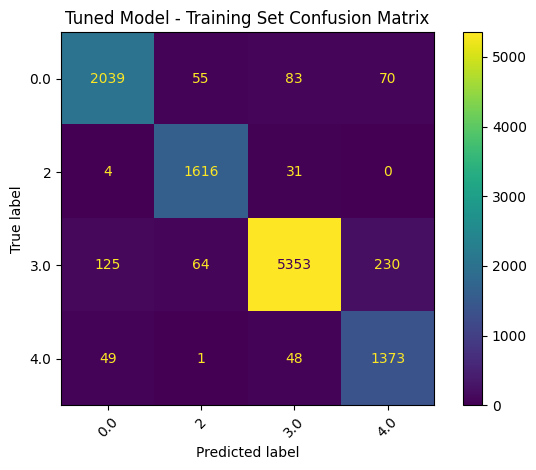


Performance when gear is stable
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94      1830
           2       0.95      1.00      0.97      1444
         3.0       0.98      0.96      0.97      5181
         4.0       0.86      0.97      0.91      1058

    accuracy                           0.96      9513
   macro avg       0.94      0.96      0.95      9513
weighted avg       0.96      0.96      0.96      9513



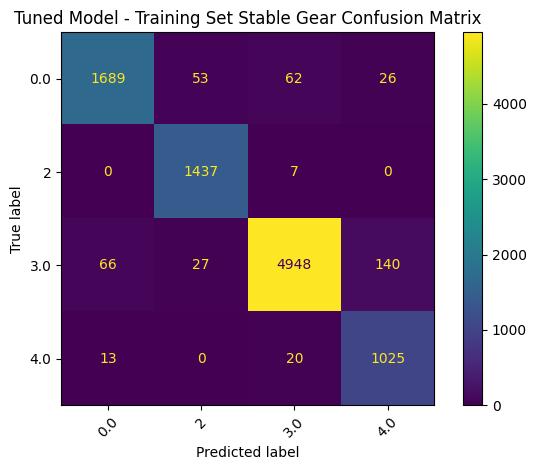


TUNED MODEL - Test Performance
              precision    recall  f1-score   support

         0.0       0.80      0.86      0.83       391
           2       0.92      0.91      0.92       360
         3.0       0.92      0.87      0.90      1414
         4.0       0.45      0.54      0.49       228

    accuracy                           0.85      2393
   macro avg       0.77      0.80      0.78      2393
weighted avg       0.86      0.85      0.85      2393




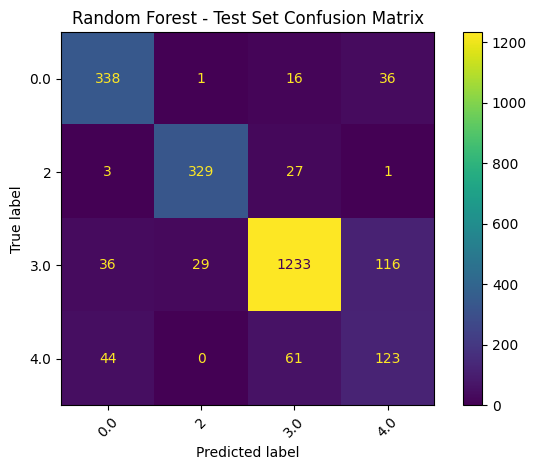


Performance when gear is stable
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91       311
           2       0.95      0.97      0.96       320
         3.0       0.96      0.89      0.93      1306
         4.0       0.41      0.66      0.50       123

    accuracy                           0.90      2060
   macro avg       0.80      0.86      0.83      2060
weighted avg       0.92      0.90      0.90      2060



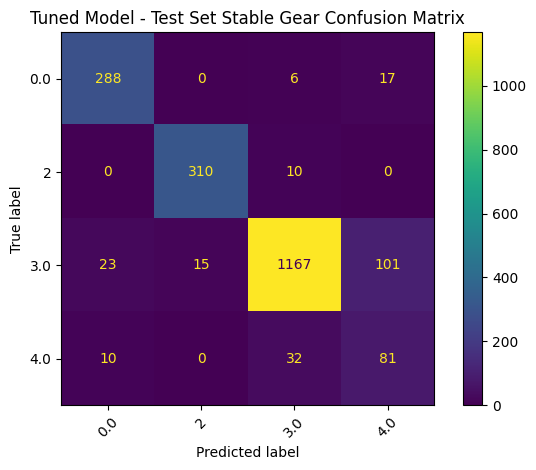

In [332]:
ALL_LABELS = sorted(y_train.unique())

rf_tuned = RandomForestClassifier(
    n_estimators=200,              # Tress
    max_depth=15,                  # Tree depth
    min_samples_split=10,          # Samples needed for a split
    min_samples_leaf=4,            # Samples needed for a leaf
    max_features='sqrt',           # Use sqrt(n_features) per split (adds randomness)
    class_weight='balanced',       # Keep this for class imbalance
    bootstrap=True,                # Enable bootstrapping
    oob_score=True,                # Get out-of-bag score (free validation estimate)
    n_jobs=-1,
    random_state=42
)

print("Training tuned Random Forest...")
rf_tuned.fit(X_train, y_train)
print(f"Out-of-bag score: {rf_tuned.oob_score_:.4f}")

pred_train = rf_tuned.predict(X_train)
pred_test = rf_tuned.predict(X_test)

print("\n" + "="*50)
print("TUNED MODEL - Training Performance")
print("="*50)
print(classification_report(y_train, pred_train))
# Confusion matrix
cm = confusion_matrix(y_train, pred_train, labels=sorted(y_train.unique()))
ConfusionMatrixDisplay(cm, display_labels=ALL_LABELS).plot(xticks_rotation=45)
plt.title("Tuned Model - Training Set Confusion Matrix")
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("Performance when gear is stable")
print("="*50)
print(classification_report_when_stable_gear(y_train, pred_train))
# Confusion matrix
cm = confusion_matrix_when_stable_gear(y_train, pred_train)
ConfusionMatrixDisplay(cm, display_labels=ALL_LABELS).plot(xticks_rotation=45)
plt.title("Tuned Model - Training Set Stable Gear Confusion Matrix")
plt.tight_layout()
plt.show()


print("\n" + "="*50)
print("TUNED MODEL - Test Performance")
print("="*50)
print(classification_report(y_test, pred_test))
print("\n" + "="*50)
# Confusion matrix
cm = confusion_matrix(y_test, pred_test, labels=sorted(y_train.unique()))
ConfusionMatrixDisplay(cm, display_labels=ALL_LABELS).plot(xticks_rotation=45)
plt.title("Random Forest - Test Set Confusion Matrix")
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("Performance when gear is stable")
print("="*50)
print(classification_report_when_stable_gear(y_test, pred_test))
# Confusion matrix
cm = confusion_matrix_when_stable_gear(y_test, pred_test)
ConfusionMatrixDisplay(cm, display_labels=ALL_LABELS).plot(xticks_rotation=45)
plt.title("Tuned Model - Test Set Stable Gear Confusion Matrix")
plt.tight_layout()
plt.show()


In [333]:
# evaluate trained model on individual skiers and print per skier results:
train_ind_dir = Path("../datasets/NR_split_on_skiers/train_val") 
train_ind_files = list(train_ind_dir.glob("*.csv"))
print(f"Training files: {len(train_ind_files)}")

test_ind_dir = Path("../datasets/NR_split_on_skiers/test")
test_ind_files = list(test_ind_dir.glob("*.csv"))

from sklearn.metrics import accuracy_score, classification_report

print("\n=== PER-SKIER TRAINING EVALUATION ===")

for file in train_ind_files:
    # Load and prepare file
    df = load_data(file)
    df = make_sure_numeric(df, feature_columns_gnss + feature_columns_pole_data)
    df['Variant'] = df['Variant'].map({'NR': 0, 'WR': 1})

    # Extract features and labels
    X_file = df[feature_columns]
    y_file = df[output_col]

    # Predict
    pred_file = rf_tuned.predict(X_file)

    # Compute accuracy
    acc = accuracy_score(y_file, pred_file)

    print(f"\nFile: {file.name}")
    print(f"  Samples: {len(df)}")
    print(f"  Accuracy: {acc:.3f}")

    # Optional: add a confusion matrix or classification report
    # print(classification_report(y_file, pred_file, digits=3))
print("\n=== PER-SKIER TESTING EVALUATION ===")

for file in test_ind_files:
    # Load and prepare file
    df = load_data(file)
    df = make_sure_numeric(df, feature_columns_gnss + feature_columns_pole_data)
    df['Variant'] = df['Variant'].map({'NR': 0, 'WR': 1})

    # Extract features and labels
    X_file = df[feature_columns]
    y_file = df[output_col]

    # Predict
    pred_file = rf_tuned.predict(X_file)

    # Compute accuracy
    acc = accuracy_score(y_file, pred_file)

    print(f"\nFile: {file.name}")
    print(f"  Samples: {len(df)}")
    print(f"  Accuracy: {acc:.3f}")

    # Optional: add a confusion matrix or classification report
    # print(classification_report(y_file, pred_file, digits=3))


Training files: 10

=== PER-SKIER TRAINING EVALUATION ===


KeyError: "['incline'] not in index"

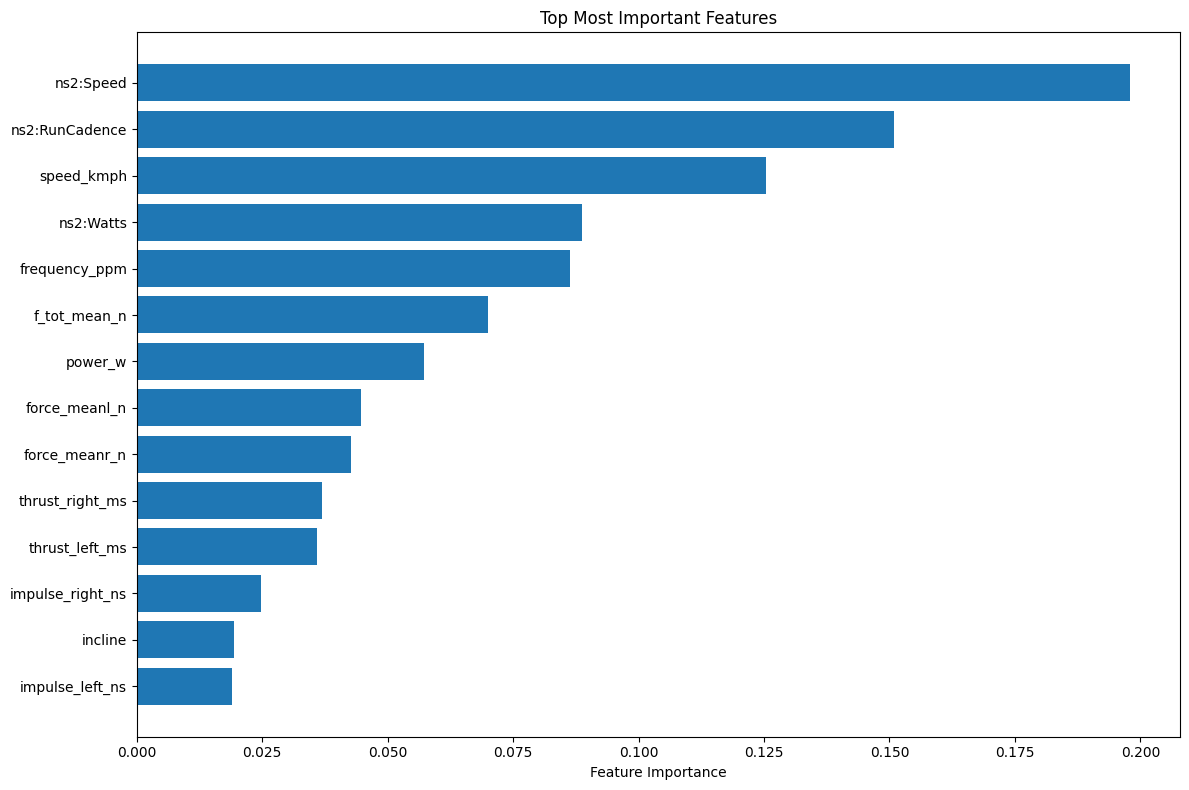


Top 10 most important features:
            feature  importance
10        ns2:Speed    0.198006
11   ns2:RunCadence    0.150953
0        speed_kmph    0.125406
12        ns2:Watts    0.088811
2     frequency_ppm    0.086337
9      f_tot_mean_n    0.070085
1           power_w    0.057172
7     force_meanl_n    0.044678
8     force_meanr_n    0.042695
4   thrust_right_ms    0.036853


In [334]:
# Analyze feature importance to understand what drives predictions
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_tuned.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(feature_importance.head(10))

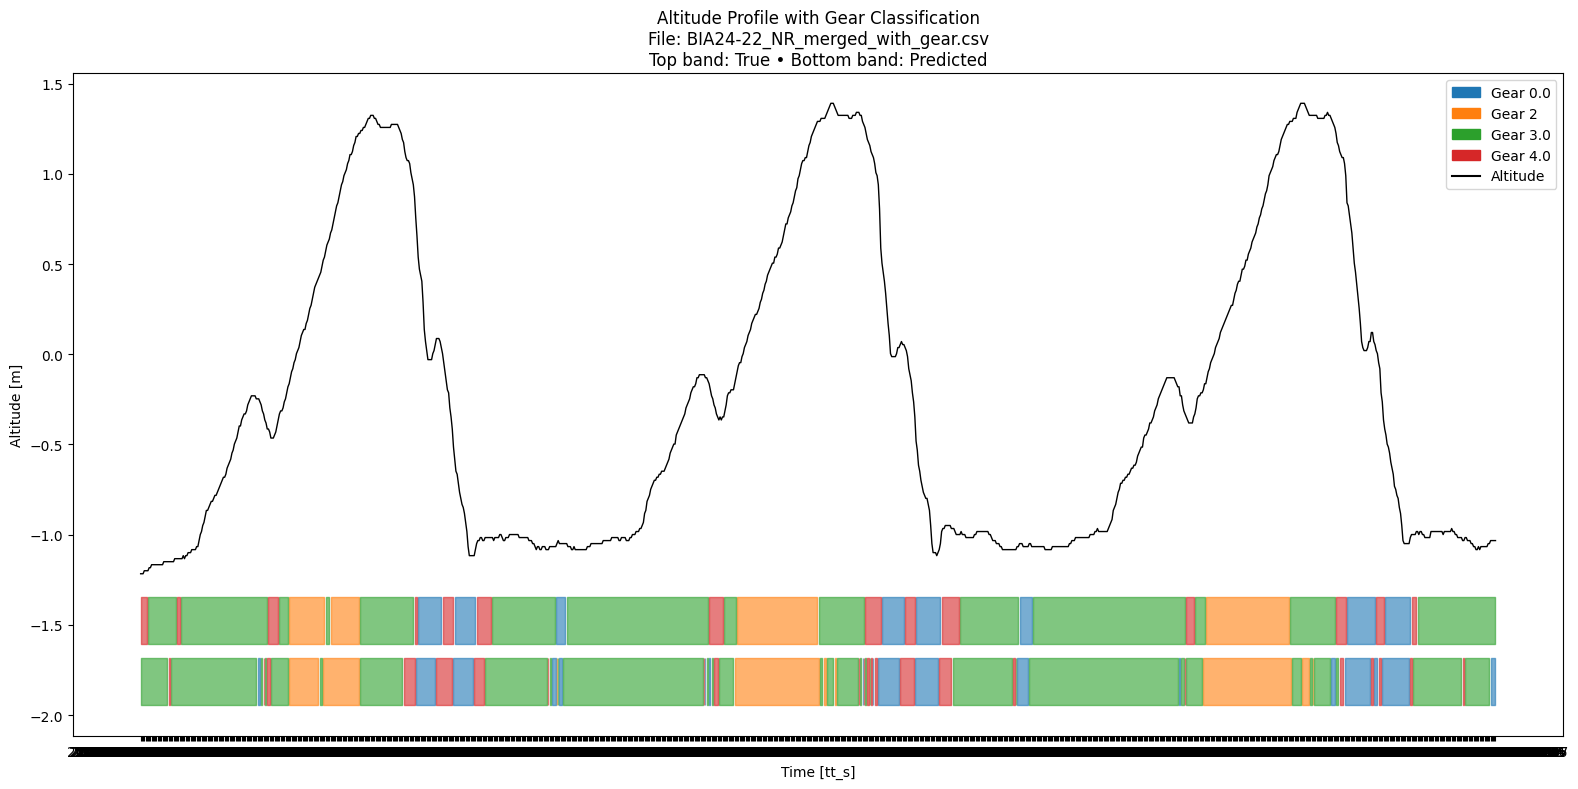

In [335]:
import matplotlib.patches as mpatches

# -----------------------------
# Choose a single test file
# -----------------------------
i = 0  # index of test file you want to plot
df_plot = test_dfs[i].copy()

# Make sure variant is encoded like in training
df_plot['Variant'] = df_plot['Variant'].map({'NR': 0, 'WR': 1})

# Sort by time just to be safe
if 'tt_s' in df_plot.columns:
    df_plot = df_plot.sort_values('tt_s').reset_index(drop=True)

# Features & labels for this file
X_file = df_plot[feature_columns]
y_file = df_plot[output_col].astype(str)

# Predictions
pred_file = rf_tuned.predict(X_file)
pred_file = pd.Series(pred_file).astype(str)

# -----------------------------
# Prepare data for plotting
# -----------------------------
if 'tt_s' in df_plot.columns:
    t = df_plot['tt_s'].values
    x_label = "Time [tt_s]"
else:
    t = df_plot.index.values
    x_label = "Frame index"

alt = df_plot['ns1:AltitudeMeters'].values

min_len = min(len(t), len(alt), len(y_file), len(pred_file))
t = t[:min_len]
alt = alt[:min_len]
true_str = y_file.values[:min_len]
pred_str = pred_file.values[:min_len]

unique_classes_str = sorted(np.unique(true_str))

# -----------------------------
# Plot altitude + gear bands
# -----------------------------
cmap = plt.get_cmap("tab10")
class_to_color = {cls: cmap(i) for i, cls in enumerate(unique_classes_str)}

plt.figure(figsize=(16, 8))

# Altitude curve
plt.plot(t, alt, color='black', linewidth=1, label="Altitude", zorder=10)

y_min, y_max = alt.min(), alt.max()
y_range = y_max - y_min if y_max > y_min else 1.0

true_band_top = y_min - 0.05 * y_range
true_band_bot = y_min - 0.15 * y_range
pred_band_top = y_min - 0.18 * y_range
pred_band_bot = y_min - 0.28 * y_range

# True gear band
for cls in unique_classes_str:
    mask = (true_str == cls)
    if np.any(mask):
        plt.fill_between(
            t, true_band_bot, true_band_top,
            where=mask,
            color=class_to_color[cls],
            alpha=0.6,
            step='mid'
        )

# Predicted gear band
for cls in unique_classes_str:
    mask = (pred_str == cls)
    if np.any(mask):
        plt.fill_between(
            t, pred_band_bot, pred_band_top,
            where=mask,
            color=class_to_color[cls],
            alpha=0.6,
            step='mid'
        )

# Legend & labels
handles = [mpatches.Patch(color=class_to_color[c], label=f"Gear {c}")
           for c in unique_classes_str]
handles.append(plt.Line2D([], [], color='black', label='Altitude'))

plt.xlabel(x_label)
plt.ylabel("Altitude [m]")
plt.title(f"Altitude Profile with Gear Classification\n"
          f"File: {test_files[i].name}\nTop band: True • Bottom band: Predicted")
plt.legend(handles=handles, loc="upper right")
plt.tight_layout()
plt.show()


In [ ]:
# implement linear regression model as baseline
from sklearn.linear_model import LogisticRegression


MLP — Train
              precision    recall  f1-score   support

         0.0       0.90      0.77      0.83      2247
           2       0.89      0.95      0.92      1651
         3.0       0.89      0.94      0.91      5772
         4.0       0.81      0.74      0.77      1471

    accuracy                           0.88     11141
   macro avg       0.87      0.85      0.86     11141
weighted avg       0.88      0.88      0.88     11141



/Users/gustafbjorn/Documents/Chalmers/CAS/TRA300 Digitalization in sports/Project/Project/tra300-ski-technique-classification/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


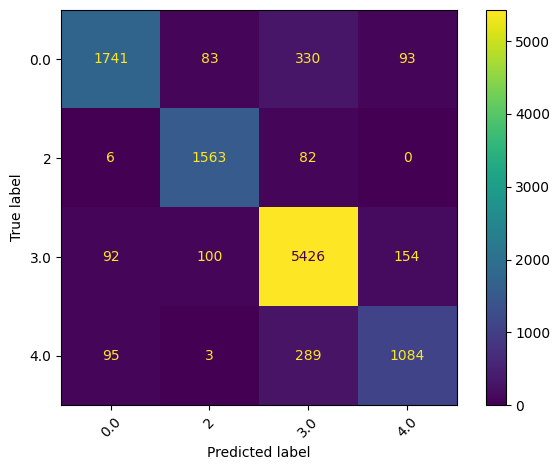

Stable gears
              precision    recall  f1-score   support

         0.0       0.95      0.79      0.87      1830
           2       0.92      0.98      0.95      1444
         3.0       0.92      0.97      0.94      5181
         4.0       0.87      0.81      0.84      1058

    accuracy                           0.92      9513
   macro avg       0.91      0.89      0.90      9513
weighted avg       0.92      0.92      0.92      9513



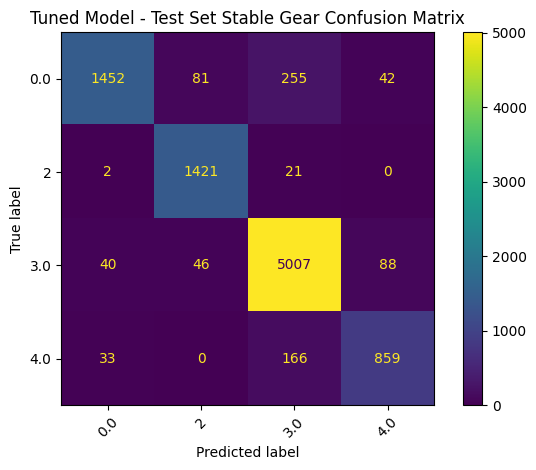

MLP — Test
              precision    recall  f1-score   support

         0.0       0.79      0.85      0.82       391
           2       0.92      0.90      0.91       360
         3.0       0.90      0.93      0.91      1414
         4.0       0.56      0.41      0.47       228

    accuracy                           0.86      2393
   macro avg       0.79      0.77      0.78      2393
weighted avg       0.85      0.86      0.85      2393



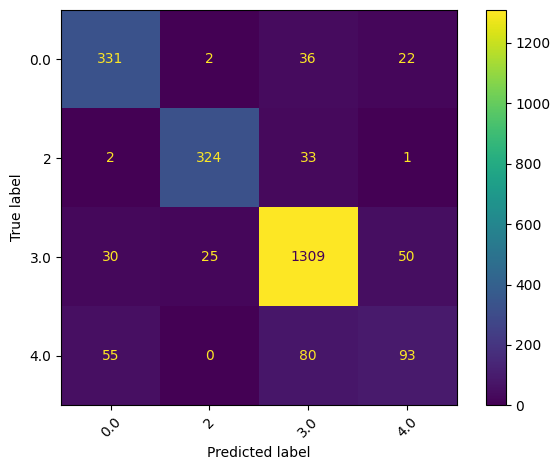

Stable gears
              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88       311
           2       0.96      0.95      0.96       320
         3.0       0.94      0.94      0.94      1306
         4.0       0.57      0.46      0.51       123

    accuracy                           0.91      2060
   macro avg       0.83      0.81      0.82      2060
weighted avg       0.91      0.91      0.91      2060



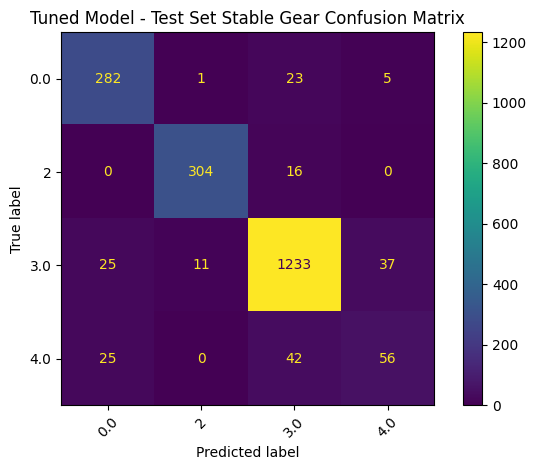

In [312]:
mlp = MLPClassifier(
    hidden_layer_sizes=(128,64), activation="relu",
    batch_size=256, max_iter=50, learning_rate="adaptive",
    random_state=42
)
mlp.fit(X_train, y_train)
pred_test_mlp = mlp.predict(X_test)
pred_train_mlp = mlp.predict(X_train)

print("MLP — Train")
print(classification_report(y_train, pred_train_mlp))
cm = confusion_matrix(y_train, pred_train_mlp, labels=sorted(y_train.unique()))
ConfusionMatrixDisplay(cm, display_labels=ALL_LABELS).plot(xticks_rotation=45)
plt.tight_layout(); plt.show()

print("Stable gears")
print(classification_report_when_stable_gear(y_train, pred_train_mlp))
# Confusion matrix
cm = confusion_matrix_when_stable_gear(y_train, pred_train_mlp)
ConfusionMatrixDisplay(cm, display_labels=ALL_LABELS).plot(xticks_rotation=45)
plt.title("Tuned Model - Test Set Stable Gear Confusion Matrix")
plt.tight_layout()
plt.show()


print("MLP — Test")
print(classification_report(y_test, pred_test_mlp))
cm = confusion_matrix(y_test, pred_test_mlp, labels=sorted(y_train.unique()))
ConfusionMatrixDisplay(cm, display_labels=ALL_LABELS).plot(xticks_rotation=45)
plt.tight_layout(); plt.show()


print("Stable gears")
print(classification_report_when_stable_gear(y_test, pred_test_mlp))
# Confusion matrix
cm = confusion_matrix_when_stable_gear(y_test, pred_test_mlp)
ConfusionMatrixDisplay(cm, display_labels=ALL_LABELS).plot(xticks_rotation=45)
plt.title("Tuned Model - Test Set Stable Gear Confusion Matrix")
plt.tight_layout()
plt.show()


